In [56]:
import numpy as np
import pandas as pd
import statistics as stats
import matplotlib
from matplotlib import pylab as plt

# Classification - target variable: rating
df = pd.read_csv('../data/sephora_website_dataset.csv')
# Drop 'MarketingFlags_content' becasue it has redundant information
groups = df['id']
df = df[df.columns.difference(['options', 'details', 'how_to_use', 'ingredients', 'URL','MarketingFlags_content','id','name','brand'])]
print(df.shape)
df.head()

(9168, 12)


,MarketingFlags,category,exclusive,limited_edition,limited_time_offer,love,number_of_reviews,online_only,price,rating,size,value_price
0,True,Fragrance,0,0,0,3002,4,1,66.0,4.0,5 x 0.16oz/5mL,75.0
1,True,Cologne,0,0,0,2700,76,1,66.0,4.5,0.7 oz/ 20 mL,66.0
2,True,Perfume,0,0,0,2600,26,1,180.0,4.5,5 oz/ 148 mL,180.0
3,True,Perfume,0,0,0,2900,23,1,120.0,4.5,2.5 oz/ 74 mL,120.0
4,True,Fragrance,0,0,0,943,2,1,72.0,3.5,5 x 0.16oz/5mL,80.0


In [57]:
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [58]:
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn import svm
from sklearn import linear_model
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

def ML_pipeline_kfold_GridSearchCV(X, y, groups, model, param_grid, random_state, n_folds):
    splitter = GroupShuffleSplit(n_splits=1,test_size=0.2,random_state=random_state)
    for i_other,i_test in splitter.split(X, y, groups):
        X_other, y_other, groups_other = X.iloc[i_other], y.iloc[i_other], groups.iloc[i_other]
        X_test, y_test, groups_test = X.iloc[i_test], y.iloc[i_test], groups.iloc[i_test]
        y_other, y_test = y_other.values.ravel(), y_test.values.ravel()

    kf = GroupKFold(n_splits=n_folds)
    
    cont_ftrs = ['love', 'number_of_reviews', 'price']
    cat_ftrs = ['MarketingFlags', 'category', 'exclusive', 'limited_edition', 'limited_time_offer','online_only']

    # one-hot encoder
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
    # standard scaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, cont_ftrs),
            ('cat', categorical_transformer, cat_ftrs)])
    
    pipe = make_pipeline(preprocessor, model)
    grid = GridSearchCV(pipe, param_grid = param_grid, scoring=make_scorer(mean_squared_error, greater_is_better=False),
                        cv=kf, return_train_score=True)
    grid.fit(X_other, y_other, groups=groups_other)
    feature_names = cont_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(cat_ftrs))
    return grid, np.array(feature_names), X_test, y_test, grid.score(X_test, y_test)

In [59]:
# Extraxt categorical columns
def cat_cols(df, col = df.columns):
    cat = []
    for name in col:
        if len(df[name].value_counts()) < 3:
            cat.append(name)
    return cat

categorical_cols = cat_cols(df)
categorical_cols.append('rating')
# Extraxt continuous columns
continuous_cols = list(df[df.columns.difference(categorical_cols)].columns)

In [60]:
df2 = df[df.columns.difference(['brand', 'id', 'name', 'size', 'value_price', 'price_level', 'unit_price'])]
X = df2.loc[:,df2.columns!='rating']
y = df2.loc[:,df2.columns=='rating']

In [61]:
# Lasso
lasso_param_grid = {'lasso__alpha': np.logspace(-3, 3, num=7)}
lasso_grid, ftrs, X_test, y_test, lasso_test_score = ML_pipeline_kfold_GridSearchCV(X, y, groups, Lasso(max_iter=1000000), lasso_param_grid, 63, 5)
lasso_results = pd.DataFrame(lasso_grid.cv_results_)
print(lasso_grid.best_estimator_)
print('best CV MSE:', -np.around(lasso_grid.best_score_, 3))
print('test MSE:', -np.around(lasso_test_score, 3))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['love', 'number_of_reviews',
                                                   'price']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['MarketingFlags', 'category',
                                                   'exclusive',
                                                   'limited_edition',
                                            

In [62]:
# Ridge
ridge_param_grid = {'ridge__alpha': np.logspace(-3, 3, num=7)}
ridge_grid, ftrs, X_test, y_test, ridge_test_score = ML_pipeline_kfold_GridSearchCV(X, y, groups, Ridge(), ridge_param_grid, 63, 5)
ridge_results = pd.DataFrame(ridge_grid.cv_results_)
print(ridge_grid.best_estimator_)
print('best CV MSE:', -np.around(ridge_grid.best_score_, 3))
print('test MSE:', -np.around(ridge_test_score, 3))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['love', 'number_of_reviews',
                                                   'price']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['MarketingFlags', 'category',
                                                   'exclusive',
                                                   'limited_edition',
                                            

In [68]:
# Elastic Net
elasticnet_param_grid = {'elasticnet__alpha': np.logspace(-3, 3, num=7),
                   'elasticnet__l1_ratio': np.linspace(0, 1, 11)}
elasticnet_grid, ftrs, X_test, y_test, elasticnet_test_score = ML_pipeline_kfold_GridSearchCV(X, y, groups, ElasticNet(max_iter=10000), elasticnet_param_grid, 63, 5)
print(elasticnet_grid.best_estimator_)
print('best CV score:', -np.around(elasticnet_grid.best_score_, 3))
print('test MSE:', -np.around(elasticnet_test_score, 3))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['love', 'number_of_reviews',
                                                   'price']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['MarketingFlags', 'category',
                                                   'exclusive',
                                                   'limited_edition',
                                            

In [69]:
# KNN
from sklearn.neighbors import KNeighborsRegressor
knn_param_grid = {'kneighborsregressor__n_neighbors': [1, 10, 30, 100],
                'kneighborsregressor__weights': ['uniform', 'distance']}
knn_grid, ftrs, X_test, y_test, knn_test_score = ML_pipeline_kfold_GridSearchCV(X, y, groups, KNeighborsRegressor(), knn_param_grid, 63, 5)
print(knn_grid.best_estimator_)
print('best CV score:', -np.around(knn_grid.best_score_, 3))
print('test MSE:', -np.around(knn_test_score, 3))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['love', 'number_of_reviews',
                                                   'price']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['MarketingFlags', 'category',
                                                   'exclusive',
                                                   'limited_edition',
                                            

In [71]:
# Random Forest
rf_param_grid = {'randomforestregressor__max_depth': np.linspace(10, 210, 11), 
                 'randomforestregressor__max_features': np.linspace(0.5, 1.0, 11)}
rf_grid, ftrs, X_test, y_test, rf_test_score = ML_pipeline_kfold_GridSearchCV(X, y, groups, RandomForestRegressor(n_estimators=100, random_state=63), 
                                                        rf_param_grid, 63, 5)
print(rf_grid.best_estimator_)
print('best CV score:', -np.around(rf_grid.best_score_, 3))
print('test MSE:', -np.around(rf_test_score, 3))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['love', 'number_of_reviews',
                                                   'price']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['MarketingFlags', 'category',
                                                   'exclusive',
                                                   'limited_edition',
                                            

In [115]:
# Random Forest with different random state
rf_param_grid2 = {'randomforestregressor__max_depth': np.linspace(10, 210, 11), 
                 'randomforestregressor__max_features': np.linspace(0.5, 1.0, 11)}
rf_grid2, ftrs, X_test, y_test, rf_test_score2 = ML_pipeline_kfold_GridSearchCV(X, y, groups, RandomForestRegressor(n_estimators=100, random_state=630), 
                                                        rf_param_grid, 630, 5)
print(rf_grid2.best_estimator_)
print('best CV score:', -np.around(rf_grid2.best_score_, 3))
print('test MSE:', -np.around(rf_test_score2, 3))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['love', 'number_of_reviews',
                                                   'price']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['MarketingFlags', 'category',
                                                   'exclusive',
                                                   'limited_edition',
                                            

In [73]:
data_model = {'Model':  ['Lasso Regression', 'Ridge Regression','Elastic Net Regularized Regression', 'K-Nearest Neighbors Regressor', 'Random Forest Regressor'],
              'parameters':  ['alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]', 
                              'alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]', 
                              'alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000], l1_ratio = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]', 
                              'n_neighbors = [1, 10, 30, 100], weights = ["distance", "uniform"]', 
                              'max_depth = [10, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210], max_features = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]']
        }
df_model = pd.DataFrame(data_model, columns = ['Model','parameters'])
df_model

,Model,parameters
0,Lasso Regression,"alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]"
1,Ridge Regression,"alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]"
2,Elastic Net Regularized Regression,"alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000], ..."
3,K-Nearest Neighbors Regressor,"n_neighbors = [1, 10, 30, 100], weights = [""di..."
4,Random Forest Regressor,"max_depth = [10, 30, 50, 70, 90, 110, 130, 150..."


In [74]:
data_model = {'Model':  ['Lasso Regression', 'Ridge Regression','Elastic Net Regularized Regression', 'K-Nearest Neighbors Regressor', 'Random Forest Regressor'],
              'Best parameters':  ['alpha = 0.001', 
                                   'alpha = 10.0', 
                                   'alpha = 0.001, l1_ratio = 0.3', 'n_neighbors = 100, weights = "distance"', 'max_depth = 30.0, max_features = 0.9'],
              'Test MSE': [1.067, 1.066, 1.066, 0.921, 0.294]
        }
# lasso_grid.best_estimator_[1]
# ridge_grid.best_estimator_[1]
# elasticnet_grid.best_estimator_[1]
# knn_grid.best_estimator_[1]
# rf_grid.best_estimator_[1]
df_model = pd.DataFrame (data_model, columns = ['Model','Best parameters', 'Test MSE'])
df_model

,Model,Best parameters,Test MSE
0,Lasso Regression,alpha = 0.001,1.067
1,Ridge Regression,alpha = 10.0,1.066
2,Elastic Net Regularized Regression,"alpha = 0.001, l1_ratio = 0.3",1.066
3,K-Nearest Neighbors Regressor,"n_neighbors = 100, weights = ""distance""",0.921
4,Random Forest Regressor,"max_depth = 30.0, max_features = 0.9",0.294


In [122]:
# test RMSE
print(round(np.sqrt(-ridge_test_score), 3))
print(round(np.sqrt(-lasso_test_score), 3))
print(round(np.sqrt(-elasticnet_test_score), 3))
print(round(np.sqrt(-knn_test_score), 3))
print(round(np.sqrt(-rf_test_score), 3))

1.033
1.033
1.032
0.96
0.549


In [124]:
# compare to test scores to a baseline score,
splitter = GroupShuffleSplit(n_splits=1,test_size=0.2,random_state=63)
for i_other,i_test in splitter.split(X, y, groups):
    X_other, y_other, groups_other = X.iloc[i_other], y.iloc[i_other], groups.iloc[i_other]

y_pred = [np.mean(y_other)] * len(y_test)
r_score_base = np.around(r2_score(y_test, y_pred), 3)
r_score_rf = np.around(r2_score(y_test, rf_grid.best_estimator_.predict(X_test)), 3)
mse_base = np.around(mean_squared_error(y_test, y_pred), 3)
mse_rf = -np.around(rf_test_score, 3)
rmse_base = np.around(np.sqrt(mse_base), 3)
rmse_rf = np.around(np.sqrt(mse_rf), 3)
print(r_score_base)
print(r_score_rf)
print(mse_base)
print(mse_rf)
print(rmse_base)
print(rmse_rf)

-0.0
0.879
1.009
0.301
1.004
0.549


In [125]:
# calculate how many standard deviations above the baseline
print(np.around(abs(rmse_rf - rmse_base)/np.std(y_test), 3))

0.453


In [77]:
# save the output so I can use it later
import pickle
file = open('../results/grid.save', 'wb')
pickle.dump((rf_grid,X_test,y_test),file)
file.close()

In [78]:
import pickle
file = open('../results/grid.save', 'rb')
grid, X_test, y_test = pickle.load(file)
file.close()

np.random.seed(63)
ftr_names = X_test.columns
nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])

test_score = rf_grid.score(X_test,y_test)
print('test score = ', -test_score)
print('test baseline = ',np.sum(y_test == 0)/len(y_test))
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling ' + str(ftr_names[i]))
    mse_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        mse_scores.append(rf_grid.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(-np.mean(mse_scores),3),'+/-',np.around(np.std(mse_scores),3))
    scores[i] = mse_scores

test score =  0.30085689448192493
test baseline =  0.04904632152588556
shuffling MarketingFlags
   shuffled test score: 0.3 +/- 0.001
shuffling category
   shuffled test score: 0.34 +/- 0.006
shuffling exclusive
   shuffled test score: 0.301 +/- 0.001
shuffling limited_edition
   shuffled test score: 0.302 +/- 0.001
shuffling limited_time_offer
   shuffled test score: 0.301 +/- 0.0
shuffling love
   shuffled test score: 0.319 +/- 0.005
shuffling number_of_reviews
   shuffled test score: 1.876 +/- 0.037
shuffling online_only
   shuffled test score: 0.301 +/- 0.001
shuffling price
   shuffled test score: 0.329 +/- 0.005


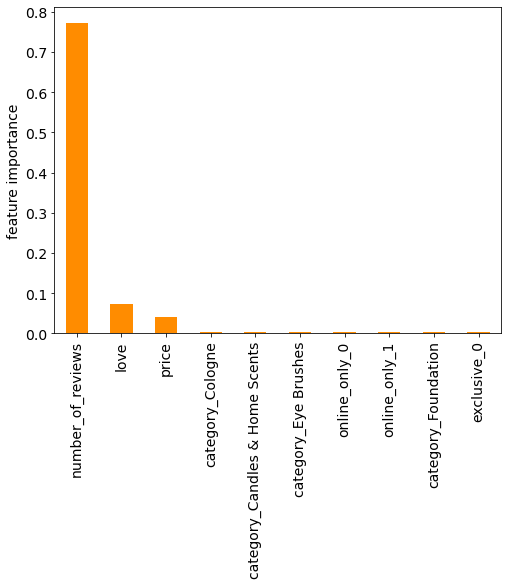

In [113]:
# 10 most important feature
indices_top = np.argsort(rf_grid.best_estimator_[1].feature_importances_)[::-1][:10]
d_top = {'ftr_imp_top': rf_grid.best_estimator_[1].feature_importances_[indices_top]}
df_top = pd.DataFrame(d_top, index=ftrs[indices_top]).plot.bar(legend=None, figsize=(8, 6), color='darkorange')
plt.ylabel('feature importance')
plt.savefig('../figures/feature_most_imp.jpg', dpi=300, bbox_inches = 'tight')
plt.show()

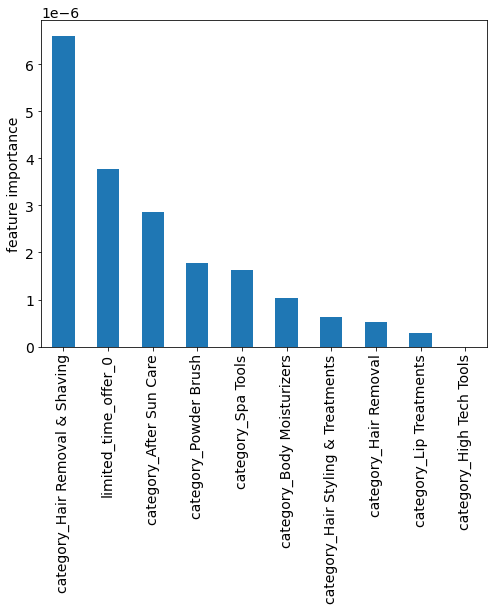

In [114]:
# 10 least important feature
indices_least = np.argsort(rf_grid.best_estimator_[1].feature_importances_)[:10][::-1]
d_least = {'ftr_imp_least': rf_grid.best_estimator_[1].feature_importances_[indices_least]}
pd.DataFrame(d_least, index=ftrs[indices_least]).plot.bar(legend=None, figsize=(8, 6))
plt.ylabel('feature importance')
plt.savefig('../figures/feature_least_imp.jpg', dpi=300, bbox_inches = 'tight')
plt.show()